In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir())


['.ipynb_checkpoints', 'dice-d4-d6-d8-d10-d12-d20', 'modelo.h5', 'Untitled.ipynb']


In [2]:
import matplotlib.pyplot as plt
import imageio
import random
import cv2
from pathlib import Path
from keras import optimizers
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense, Activation, SeparableConv2D, Lambda, DepthwiseConv2D, ZeroPadding2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, Callback

In [3]:
os.listdir('dice-d4-d6-d8-d10-d12-d20/dice/train')

['d10', 'd12', 'd20', 'd4', 'd6', 'd8']

In [4]:
tr_dir = 'dice-d4-d6-d8-d10-d12-d20/dice/train'
val_dir = 'dice-d4-d6-d8-d10-d12-d20/dice/valid'

C:\Users\Admin\AppData\Local\Temp\ipykernel_9228\2686728621.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im=imageio.imread(file)


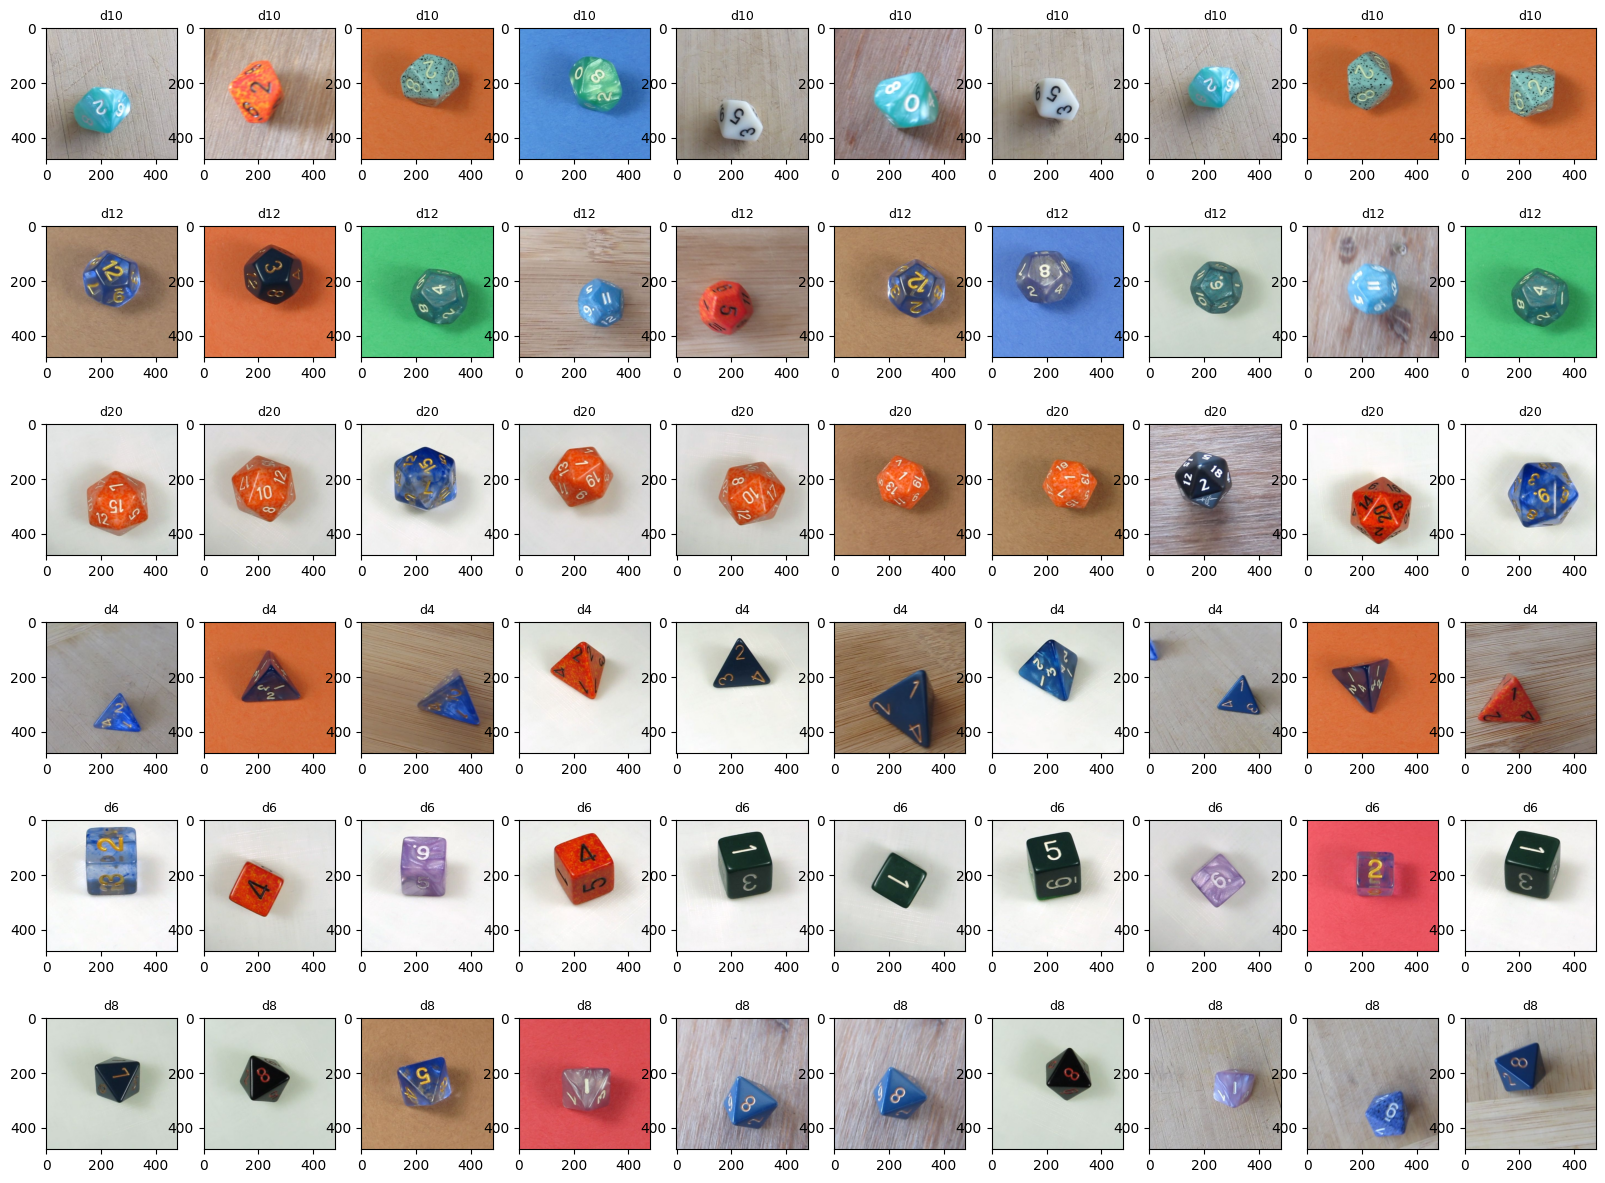

In [5]:
row, col = len(os.listdir(tr_dir)), 10
i = 0
_, ax = plt.subplots(row,col, figsize=(20,15))

for d in os.listdir(tr_dir):
    j = 0
    files  = random.sample(os.listdir(tr_dir +"/"+ d), col)
    for file in files:
        file = tr_dir +"/"+ d + "/" + file
        im=imageio.imread(file)
        ax[i,j].imshow(im,resample=True)
        ax[i,j].set_title(d, fontsize=9)
        j += 1
    i +=1
    
plt.show()

In [6]:
iwidth, iheight = 64, 64
batch_size = 16

In [12]:
Datagen = ImageDataGenerator(
    rotation_range = 360,
    rescale=1. / 255,
    shear_range=0.15,
    zoom_range=0.1,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True,
    #vertical_flip = True,
    #fill_mode='nearest',
    #validation_split=0.2
    )

In [13]:
train_generator = Datagen.flow_from_directory(
    tr_dir,
    target_size=(iheight, iwidth),
    batch_size=batch_size,
    class_mode='categorical',
    )

Found 14284 images belonging to 6 classes.


In [14]:
validation_generator = Datagen.flow_from_directory(
    val_dir,
    target_size=(iheight, iwidth),
    batch_size=batch_size,
    class_mode='categorical',
    )

Found 2102 images belonging to 6 classes.


In [15]:
num_classes = len(train_generator.class_indices.keys())
train_num = train_generator.samples
val_num = validation_generator.samples 
num_classes

6

In [16]:
minput = Input(shape=(iheight, iwidth, 3))
def addlayers(m, c, d = False):
    m = Conv2D(c, kernel_size=(3, 3), activation ='relu')(m)
    m = Conv2D(c, kernel_size=(5, 5), activation ='relu' , padding='same')(m)
    if d:
        m = DepthwiseConv2D(kernel_size=(3, 3), activation ='relu')(m)
    m = Conv2D(c, kernel_size=(3, 3), activation ='relu')(m)
    m = MaxPooling2D(pool_size = (2, 2))(m)
    m = BatchNormalization()(m)
    return m

bp = ZeroPadding2D((1,1))(minput)

p1 = addlayers(bp, 64)
p2 = addlayers(p1, 126)
p3 = addlayers(p2, 256, True)

fp =  Dropout(0.5)(p3)

fp = Flatten()(fp)

fp = Dense(512, activation = "relu")(fp)
fp = Dropout(0.4)(fp)
fp = Dense(1024, activation = "relu")(fp)
fp = Dropout(0.5)(fp)
fp = Dense(num_classes, activation = "softmax")(fp)

model = Model(inputs=minput, outputs=fp)

In [17]:
model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

C:\Users\Admin\miniconda3\envs\gpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
history = model.fit(train_generator,
                              steps_per_epoch = train_num // batch_size,
                              epochs=15,
                              validation_data = validation_generator,
                              validation_steps = val_num // batch_size,
                     
                              verbose = 2
                             )

Epoch 1/15
892/892 - 125s - loss: 0.3394 - accuracy: 0.5045 - val_loss: 0.3103 - val_accuracy: 0.6026 - 125s/epoch - 140ms/step
Epoch 2/15
892/892 - 47s - loss: 0.1903 - accuracy: 0.7552 - val_loss: 0.2286 - val_accuracy: 0.7385 - 47s/epoch - 53ms/step
Epoch 3/15
892/892 - 48s - loss: 0.1170 - accuracy: 0.8656 - val_loss: 0.1285 - val_accuracy: 0.8802 - 48s/epoch - 53ms/step
Epoch 4/15
892/892 - 49s - loss: 0.0820 - accuracy: 0.9077 - val_loss: 0.1795 - val_accuracy: 0.8383 - 49s/epoch - 55ms/step
Epoch 5/15
892/892 - 55s - loss: 0.0598 - accuracy: 0.9346 - val_loss: 0.1134 - val_accuracy: 0.9103 - 55s/epoch - 62ms/step
Epoch 6/15
892/892 - 49s - loss: 0.0475 - accuracy: 0.9518 - val_loss: 0.1485 - val_accuracy: 0.8702 - 49s/epoch - 55ms/step
Epoch 7/15
892/892 - 51s - loss: 0.0362 - accuracy: 0.9629 - val_loss: 0.1498 - val_accuracy: 0.8826 - 51s/epoch - 57ms/step
Epoch 8/15
892/892 - 49s - loss: 0.0321 - accuracy: 0.9661 - val_loss: 0.2580 - val_accuracy: 0.8030 - 49s/epoch - 55ms/st

In [19]:
model.save("modelo.h5")